# **🌲Prepare Environment**

In [ ]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import gdown

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

# Oversampling
from imblearn.over_sampling import SMOTE

# Other
from tensorflow import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
from google.colab import drive

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report

# For model serialization
import joblib
import os

In [ ]:
# Get Data
url1 = 'https://drive.google.com/uc?id=1pfF0WY1tQiJODBtk96gQzXsGPeZJ8QUn'
output1 = 'Simulation Measurement_2nd dataset.csv'
gdown.download(url1, output1, quiet=False)

url2 = 'https://drive.google.com/uc?id=17kLEwQNjgDkOo8nQujwvaDL8bAcne13Y'
output2 = 'Simulation Measurements.csv'
gdown.download(url2, output2, quiet=False)

# Load Data into DataFrames
# 15 sec dataset time duration for training
training_data =  pd.read_csv("Simulation Measurement_2nd dataset.csv",
                     header=None,usecols=[19, 23],names=['Time','Current'])
# 6 sec dataset time duration for test
test_data =  pd.read_csv("Simulation Measurements.csv",
                     header=None,usecols=[0, 4],names=['Time','Current'])

Downloading...
From: https://drive.google.com/uc?id=1pfF0WY1tQiJODBtk96gQzXsGPeZJ8QUn
To: /content/Simulation Measurement_2nd dataset.csv
100%|██████████| 74.6M/74.6M [00:00<00:00, 81.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=17kLEwQNjgDkOo8nQujwvaDL8bAcne13Y
To: /content/Simulation Measurements.csv
100%|██████████| 27.2M/27.2M [00:00<00:00, 47.6MB/s]


In [ ]:
training_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
299996,14.99980,-0.979724
299997,14.99985,-0.954137
299998,14.99990,-0.927560
299999,14.99995,-0.900309


In [ ]:
test_data

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
119996,5.99980,-0.596946
119997,5.99985,-0.579137
119998,5.99990,-0.556793
119999,5.99995,-0.528649


---
# **⚙️Data Preprocessing**


Variables: **X_res** | **y_res** | **X_test** | **y_test**

X = features | y = labels

### 1. Filter data to only certain time frame

In [ ]:
# Filter data by time
training_data = training_data[training_data['Time'] <= 5.4]
test_data = test_data[test_data['Time'] <= 2.4]

In [ ]:
display(training_data)

,Time,Current
0,0.00000,-0.807514
1,0.00005,-0.806968
2,0.00010,-0.806291
3,0.00015,-0.804651
4,0.00020,-0.801798
...,...,...
107996,5.39980,-1.908952
107997,5.39985,-1.874042
107998,5.39990,-1.838998
107999,5.39995,-1.803907


### 2. Split training data to: Normal or Fault



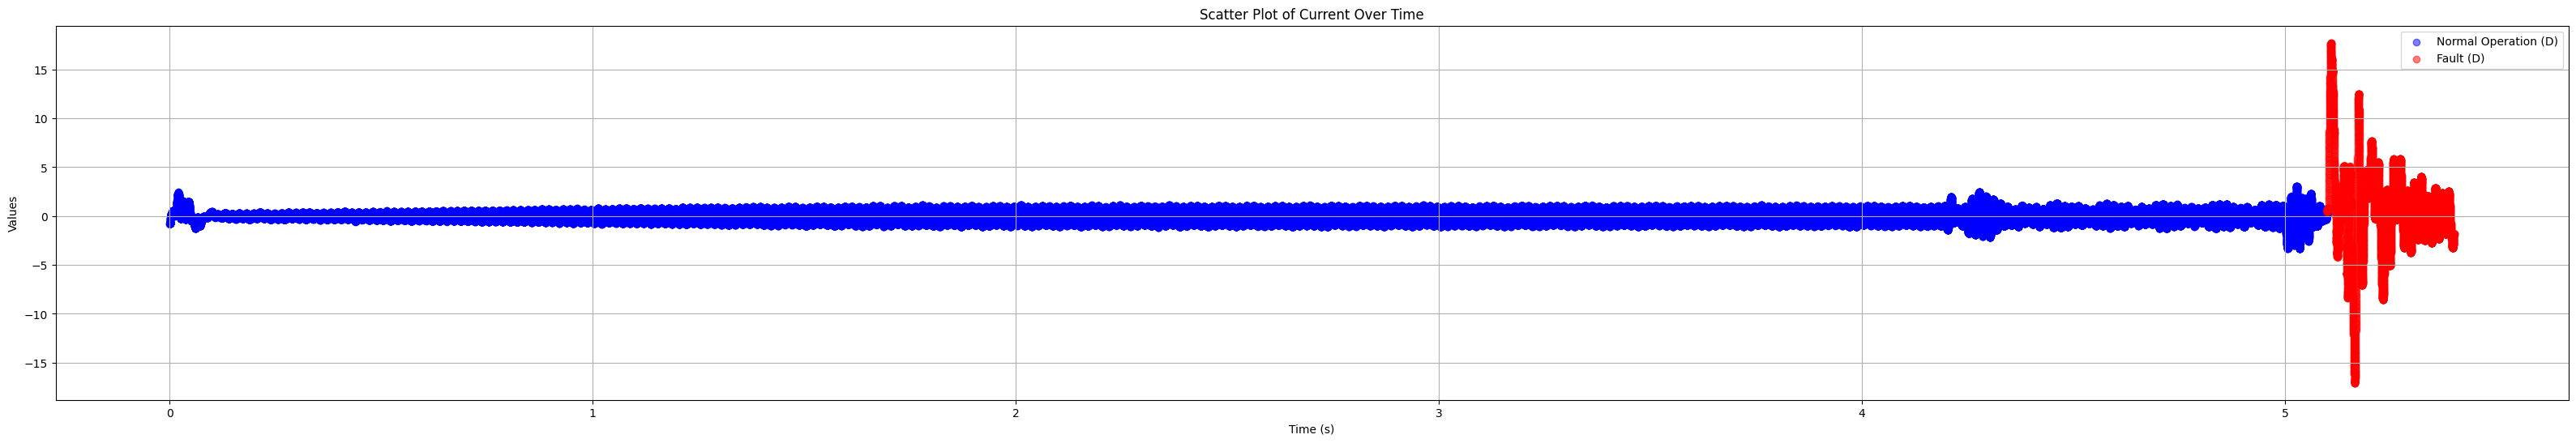

In [ ]:
# Training Data: Separate Normal and Fault data
import matplotlib.pyplot as plt

df = training_data
fault_start = 5.1
fault_end = 5.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]

plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)

plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

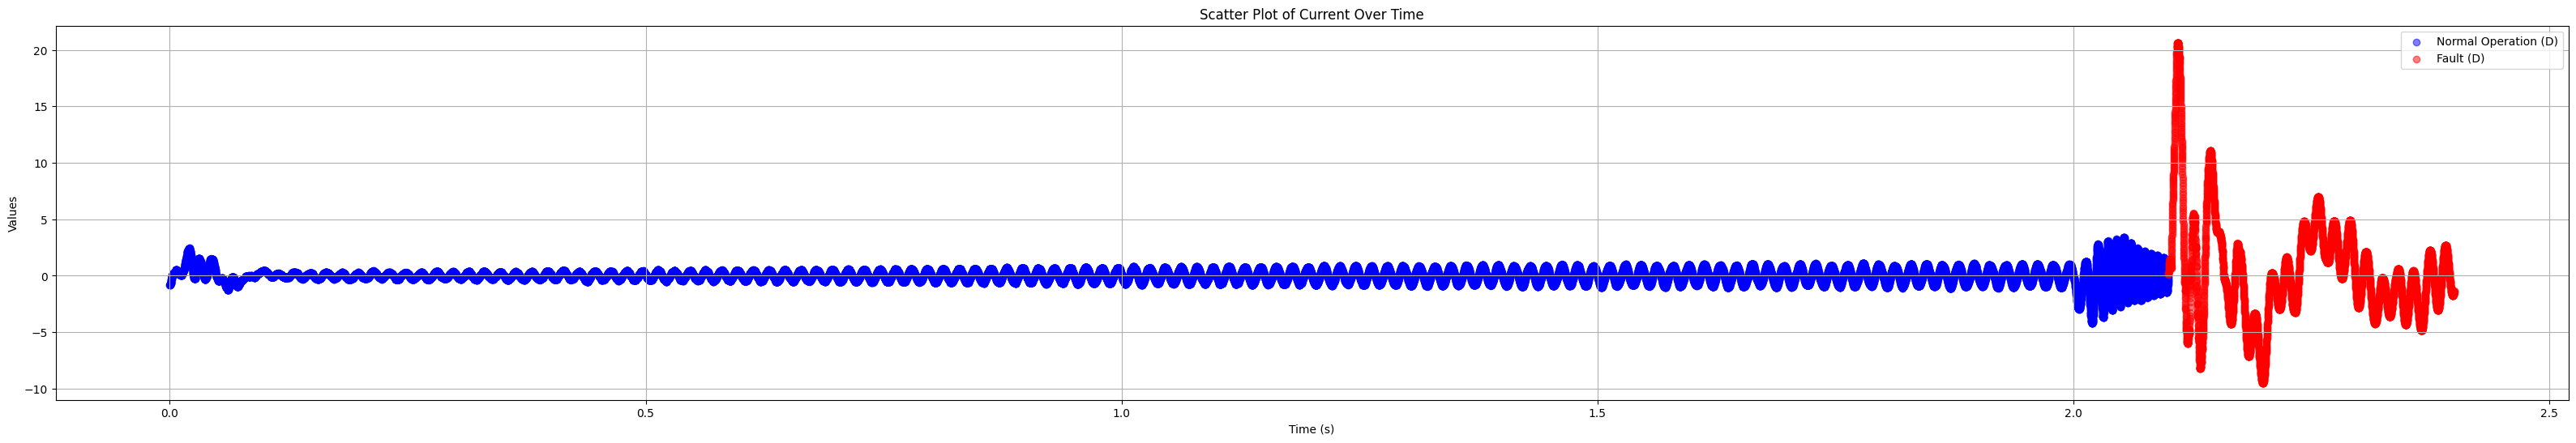

In [ ]:
# Test Data: Separate Normal and Fault data
import matplotlib.pyplot as plt

df = test_data
fault_start = 2.1
fault_end = 2.4
# Separate the data points
fault_data = df[(df['Time'] >= fault_start) & (df['Time'] <= fault_end)]
normal_data = df[(df['Time'] < fault_start) | (df['Time'] > fault_end)]

plt.figure(figsize=(40, 6))

# Plotting for column D
plt.scatter(normal_data['Time'], normal_data['Current'], c='blue', label='Normal Operation (D)', alpha=0.5)
plt.scatter(fault_data['Time'], fault_data['Current'], c='red', label='Fault (D)', alpha=0.5)


plt.title('Scatter Plot of Current Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### 3. Label Data Points to: Normal or Oscilation <-- Set **Ngram** / **Overlap** Here

In [ ]:
# Define Segmenting and Labeling function

def segment_labeling(data, window, overlap, time1, time2):

  # Define the number of data points per segment = window size

  #index determines the start of a window
  #in each step of segmenting loop
  index = 0

  #windolap incorporates overlaping percentage
  windolap = math.floor (window * overlap) # labels any data

  # Create an empty DataFrame for storing the labels
  labels_df = pd.DataFrame(columns=['label'])

  time_series = []

  # Initialize a counter for the number of ngrams (segments)
  ngram_count = 0

  while (index + window) < len(data):
      # Extract a segment of data
      segment = data.iloc[index : (index+window)]

      # Labeling based on a given time (the oscillation time is given)
      if any((time1 <= t <= time2) for t in segment['Time']):
        label = 'oscillation'
      else:
        label = 'normal'

      time_series.append(segment['Current'])

      # Append the label to the labels DataFrame
      labels_df = pd.concat([labels_df, pd.DataFrame({'label': [label]})], ignore_index=True)

      # Increase the ngram (segment) counter
      ngram_count += 1

      #Shifting the index forward by stride = window - windolap
      index += window - windolap

      #Verifying segmenting algorithm correctness by ploting
      #and visually inspecting frame by frame

      # print(index)
      # plt.plot(segment['Time'], segment['Current'])
      # plt.title(labels_df['label'][counter])
      # plt.xlabel('Time')
      # plt.ylabel('Currrent')
      # plt.show()
      # plt.clf()

  # return time_series as a list of Series (type() = list) and
  # return lables_df as a DataFrame
  return time_series, labels_df, ngram_count

In [ ]:
# Modify These Values
window = 280 # number of data points in each segment
overlap = 0.50 # overlap between segments

# Segment and Label Data
train_X, train_y, train_ngrams = segment_labeling(training_data, window, overlap, 5.1, 5.4)
test_X, test_y, test_ngrams = segment_labeling(test_data, window, overlap, 2.1, 2.4)

# Print the number of ngrams (segments) in the training and testing sets
print("Number of Ngrams in Training Set:", train_ngrams)
print("Number of Ngrams in Testing Set:", test_ngrams)

Number of Ngrams in Training Set: 770
Number of Ngrams in Testing Set: 341


In [ ]:
train_y.value_counts()

label      
normal         727
oscillation     43
Name: count, dtype: int64

In [ ]:
test_y.value_counts()

label      
normal         299
oscillation     42
Name: count, dtype: int64

In [ ]:
X_train = np.array(train_X)
X_test = np.array(test_X)

In [ ]:
X_train.shape

(770, 280)

In [ ]:
X_test.shape

(341, 280)

### 4. Encode labels (normal/oscillation) into integers to categorize them

In [ ]:
label_encoder = LabelEncoder()

# Fit and transform train
y_train = label_encoder.fit_transform(train_y.values.ravel())
# Transform only test
y_test = label_encoder.transform(test_y.values.ravel())

### 5. Normalization adjusts data into specific range (-1 to 1)

In [ ]:
from sklearn.preprocessing import Normalizer # NORMALIZED

# print("Train Before Normalization:")
# print(X_train)

# Create an instance of normalizer
normalizer = Normalizer()

# Fit normalizer on the train test and perform normalization on the train
# (fit and transform)
X_train = normalizer.fit_transform(X_train)


print("\nTrain After Normalization:")
print(X_train)


Train After Normalization:
[[-0.13921356 -0.13911944 -0.13900259 ...  0.05508746  0.0577285
   0.06258989]
 [ 0.02599219  0.02579822  0.02525944 ...  0.11658276  0.11558752
   0.11540283]
 [ 0.01609087  0.01661266  0.01676888 ...  0.01490949  0.01583681
   0.01699786]
 ...
 [ 0.05415411  0.05555298  0.05693036 ...  0.00052771  0.00217638
   0.00382687]
 [-0.00456048 -0.00610472 -0.00765231 ...  0.05051689  0.04907711
   0.04761788]
 [ 0.00420948  0.00552965  0.0067717  ... -0.09359036 -0.09345565
  -0.09330009]]


In [ ]:
X_test = normalizer.transform(X_test) # TRANSFORMED

print("\nTest After Normalization:")
print(X_test)


Test After Normalization:
[[-0.13921356 -0.13911944 -0.13900259 ...  0.05508746  0.0577285
   0.06258989]
 [ 0.02599219  0.02579822  0.02525944 ...  0.11658276  0.11558752
   0.11540283]
 [ 0.01609087  0.01661266  0.01676888 ...  0.01490949  0.01583681
   0.01699786]
 ...
 [-0.12419344 -0.12397792 -0.12373308 ... -0.0331544  -0.03440297
  -0.03564013]
 [ 0.04852898  0.04954027  0.05052553 ... -0.00997003 -0.00829636
  -0.00662159]
 [-0.03924076 -0.04052751 -0.04180452 ...  0.03286092  0.0316797
   0.03044869]]


### 6. Oversampling with SMOTE (Synthetic Minority Over-sampling): adding more samples to balance dataset

In [ ]:
from collections import Counter # XRES YRES
from imblearn.over_sampling import SMOTE

print('Original dataset shape %s' % Counter(y_train))

# Perform oversampling on the train set
sm = SMOTE()

# Check if minority sample size is less than 6, set neighbor to k-1
# k = minority sample size

k = train_y.value_counts()["oscillation"]

if k <= 5:
  sm = SMOTE(k_neighbors = k - 1)

X_res, y_res = sm.fit_resample(X_train, y_train) # OVERSAMPLED: taking train data, add extra samples that are simple to true, LOOK INTO SMOTE()

# Print the new label distribution after oversampling
oversampled_label_counts = pd.Series(y_res).value_counts()

print("\nAfter Oversampling")
print(oversampled_label_counts)

print("\nOversampled test shape")
print(X_res.shape)

Original dataset shape Counter({0: 727, 1: 43})

After Oversampling
0    727
1    727
Name: count, dtype: int64

Oversampled test shape
(1454, 280)


---

# **🌐CNN Model**

### 1. Create Model

In [ ]:
from tensorflow import keras
from keras import layers
from keras import regularizers


model = keras.Sequential()
model.add(layers.Conv1D(filters= 64, kernel_size=3, activation='relu', input_shape=(window, 1), padding='same'))
model.add(layers.Conv1D(filters= 64, kernel_size=3, activation='relu', padding='same'))
model.add(layers.Conv1D(filters= 64, kernel_size=3, strides = 2 ,activation='relu', padding='same'))
model.add(layers.Conv1D(filters= 64, kernel_size=3, strides = 2 ,activation='relu', padding='same'))


model.add(layers.Dropout(0.5)) # drops random fraction of input to prevent overfitting
model.add(layers.Flatten()) # convert multidimensional output into singledimentional array
model.add(layers.Dense(100, activation='relu')) # activation function
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid')) # for binary classification

model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 280, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 280, 64)           12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 140, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 70, 64)            12352     
                                                                 
 dropout (Dropout)           (None, 70, 64)            0         
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 100)               4

### 2. Training Model: Fit data into model

In [ ]:
batch_train = 512
batch_test = 1

model.fit(X_res, y_res, epochs=20, batch_size=batch_train)

Epoch 1/20
3/3 [==============================] - 4s 528ms/step - loss: 0.6929 - accuracy: 0.5220
Epoch 2/20
3/3 [==============================] - 2s 491ms/step - loss: 0.6886 - accuracy: 0.5887
Epoch 3/20
3/3 [==============================] - 2s 503ms/step - loss: 0.6790 - accuracy: 0.5413
Epoch 4/20
3/3 [==============================] - 2s 485ms/step - loss: 0.6623 - accuracy: 0.5880
Epoch 5/20
3/3 [==============================] - 2s 701ms/step - loss: 0.6436 - accuracy: 0.5956
Epoch 6/20
3/3 [==============================] - 2s 798ms/step - loss: 0.6378 - accuracy: 0.5928
Epoch 7/20
3/3 [==============================] - 2s 499ms/step - loss: 0.6073 - accuracy: 0.6726
Epoch 8/20
3/3 [==============================] - 1s 479ms/step - loss: 0.5936 - accuracy: 0.6637
Epoch 9/20
3/3 [==============================] - 2s 496ms/step - loss: 0.5717 - accuracy: 0.7008
Epoch 10/20
3/3 [==============================] - 2s 489ms/step - loss: 0.5619 - accuracy: 0.7146
Epoch 11/20
3/3 [==

### 3. Evaluate Model

In [ ]:
from sklearn.metrics import classification_report

# Get the model predictions for the train set
train_res_pred = model.predict(X_res, batch_size=batch_test)
train_res_pred = np.round(train_res_pred).astype(int)

# Print the classification report
print("Train")
target_names = ['normal', 'oscillation']
print(classification_report(y_res, train_res_pred, target_names = target_names))

1454/1454 [==============================] - 3s 2ms/step
Train
              precision    recall  f1-score   support

      normal       0.71      0.87      0.78       727
 oscillation       0.83      0.64      0.72       727

    accuracy                           0.75      1454
   macro avg       0.77      0.75      0.75      1454
weighted avg       0.77      0.75      0.75      1454



In [ ]:
from sklearn.metrics import classification_report

# Get the model predictions for the test set
test_pred = model.predict(X_test, batch_size=batch_test)
test_pred = np.round(test_pred).astype(int)

# Print the classification report
print("Test")
target_names = ['normal', 'oscillation']
print(classification_report(y_test, test_pred, target_names = target_names))

341/341 [==============================] - 1s 3ms/step
Test
              precision    recall  f1-score   support

      normal       0.94      0.85      0.89       299
 oscillation       0.37      0.64      0.47        42

    accuracy                           0.82       341
   macro avg       0.66      0.74      0.68       341
weighted avg       0.87      0.82      0.84       341



# **📏Support Vector Machine**

### 1. Create SVM Model w/ Linear Kernel

In [ ]:
from sklearn import svm
from sklearn.svm import SVC

In [ ]:
svm_model = SVC(kernel='linear', C=1)
# C = regulization / balance low-error on training data and minimizing complexity
# High C: Prioritize correctly classifying at expense of genralization -> overfitting
# Low C: Prioritize simplifying / smoother descisions, allows some misclassification -> better generlization, reducing overfitting risk

In [ ]:
import time

start_time = time.time() #
svm_model.fit(X_res, y_res) # train Model
train_time = time.time() - start_time
print("Train time:", train_time, "seconds")

Train time: 50.76326584815979 seconds


### 2.1. Evaluate Mode: Training Data

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Get Predictions from SVM Model
start_time = time.time() # get time
y_train_pred = svm_model.predict(X_train) # get Prediction; Input 'X' = features
test_time_entire_dataset = time.time() - start_time
test_time_per_sample = test_time_entire_dataset / len(X_test)
print("Test time for entire dataset:", test_time_entire_dataset, "seconds")
print("Test time per sample:", test_time_per_sample, "seconds")

# Calculate Accuracy and Generate a Classification Report
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print("Train Classification Report:")
print(train_report) # Training Report

Test time for entire dataset: 0.10581207275390625 seconds
Test time per sample: 0.0003102993335891679 seconds
Train Accuracy: 94.16%
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       727
           1       0.46      0.26      0.33        43

    accuracy                           0.94       770
   macro avg       0.71      0.62      0.65       770
weighted avg       0.93      0.94      0.93       770



### 2.2. Evaluate Model: Testing Data

In [ ]:
# Get Predictions from SVM Model
start_time = time.time() # get time
y_test_pred = svm_model.predict(X_test) # get Prediction
test_time_entire_dataset = time.time() - start_time
test_time_per_sample = test_time_entire_dataset / len(X_test)
print("Test time for entire dataset:", test_time_entire_dataset, "seconds")
print("Test time per sample:", test_time_per_sample, "seconds")

# Calculate Accuracy and Generate a Classification Report
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:")
print(test_report) # Testing Data

Test time for entire dataset: 8.245230913162231 seconds
Test time per sample: 0.0025920248076586705 seconds

Test Accuracy: 88.09%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2781
           1       0.54      0.33      0.41       400

    accuracy                           0.88      3181
   macro avg       0.73      0.65      0.67      3181
weighted avg       0.86      0.88      0.87      3181



In [ ]:
import os
import joblib  # library to save and load models

# Save the model to disk
joblib.dump(svm_model, "svm_model.pkl")

# Get the file size of the saved model
model_size = os.path.getsize("svm_model.pkl")

print("Model Size:", model_size)

Model Size: 2862795


### 3. Visualization
Testing, trying to get it to work

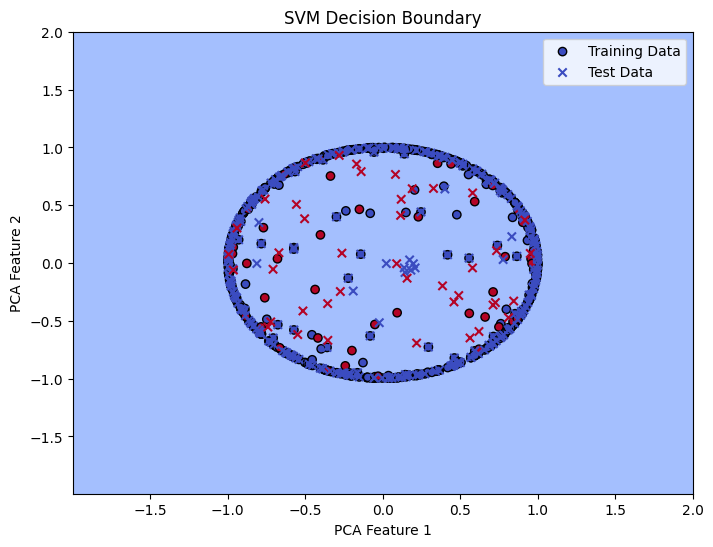

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Reduce the training and testing data to 2D
pca = PCA(n_components=2)  # Instance of Principal Component Analysis with 2 dimensions
X_train_2D = pca.fit_transform(X_train)  # Project the training data
X_test_2D = pca.transform(X_test)        # Project the testing data

# Fit a new SVM on the 2D projected data
svm_2D = SVC(kernel='linear', C=1)  # Using a linear kernel for simplicity
svm_2D.fit(X_train_2D, y_train)    # Fit the SVM with the 2D training data

# Create a mesh grid for visualization
x_min, x_max = X_train_2D[:, 0].min() - 1, X_train_2D[:, 0].max() + 1
y_min, y_max = X_train_2D[:, 1].min() - 1, X_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict the class for each point in the mesh grid
Z = svm_2D.predict(np.c_[xx.ravel(), yy.ravel()])  # Predict for each point in the mesh
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)  # Decision boundary

# Plot the training data
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k', label='Training Data')
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x', label='Test Data')  # Removed edgecolors for unfilled marker

plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary")
plt.legend()
plt.show()

# **🌳Random Forest**

### 1. Create Model: 100 Trees, Max Depth = 10

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42) # create Random Forest

random_forest.fit(X_res, y_res) # train Model

RandomForestClassifier(max_depth=10, random_state=42)

### 2. Evaluate

In [ ]:
# Make predictions on the test data
y_test_pred = random_forest.predict(X_test)
y_test_pred = random_forest.predict(X_test)

# Evaluate Training Data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred, target_names=['normal', 'oscillation'])

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print("Train Classification Report:")
print(train_report)

# Evaluate Testing Data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, target_names=['normal', 'oscillation'])

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:")
print(test_report)

Train Accuracy: 94.16%
Train Classification Report:
              precision    recall  f1-score   support

      normal       0.96      0.98      0.97       727
 oscillation       0.46      0.26      0.33        43

    accuracy                           0.94       770
   macro avg       0.71      0.62      0.65       770
weighted avg       0.93      0.94      0.93       770


Test Accuracy: 92.96%
Test Classification Report:
              precision    recall  f1-score   support

      normal       0.95      0.97      0.96       299
 oscillation       0.74      0.67      0.70        42

    accuracy                           0.93       341
   macro avg       0.85      0.82      0.83       341
weighted avg       0.93      0.93      0.93       341



# **🔋XGBoost**

### 1. Create XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_res, label=y_res)   # Balanced training data
dtest = xgb.DMatrix(X_test, label=y_test)  # Testing data

# Set parameters for the XGBoost model
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "error",          # Evaluation metric (error rate)
    "max_depth": 6,                  # Maximum tree depth
    "eta": 0.1,                      # Learning rate
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)  # 100 boosting rounds

### 2. Evaluate Model

In [ ]:
# Make predictions on the training and testing data
y_train_pred = (xgb_model.predict(dtrain) > 0.5).astype(int)  # Predictions for training data
y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)  # Predictions for testing data

# Evaluate the XGBoost model on the training data
train_accuracy = accuracy_score(y_res, y_train_pred)
train_report = classification_report(y_res, y_train_pred, target_names=['normal', 'oscillation'])

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print("Train Classification Report:")
print(train_report)

# Evaluate the XGBoost model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, target_names=['normal', 'oscillation'])

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report:")
print(test_report)

Train Accuracy: 99.72%
Train Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00       727
 oscillation       1.00      1.00      1.00       727

    accuracy                           1.00      1454
   macro avg       1.00      1.00      1.00      1454
weighted avg       1.00      1.00      1.00      1454


Test Accuracy: 92.38%
Test Classification Report:
              precision    recall  f1-score   support

      normal       0.95      0.96      0.96       299
 oscillation       0.71      0.64      0.67        42

    accuracy                           0.92       341
   macro avg       0.83      0.80      0.82       341
weighted avg       0.92      0.92      0.92       341



---

---
# **📚Textbook Code Snippets**

In [ ]:
# Textbook Snippet: Trains Linear SVM to detect Virgin ica Flowers
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2) # Iris virginica

svm_clf = make_pipeline(StandardScaler(), LinearSVC(C=1, random_state=42))
svm_clf.fit(X, y)

In [ ]:
# Textbook Snippet: PolynormialFeatures Transformer -> StandardScaler + LinearCVS classifier
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
polynomial_svm_clf = make_pipeline(PolynomialFeatures(degree=3),
                                   StandardScaler(),
                                   LinearSVC(C=10, max_iter=10_000, random_state=42)
                                   )
polynomial_svm_clf.fit(X, y)

In [ ]:
# Textbook Snippet: Kernel Trick
from sklearn.svm import SVC
poly_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X, y)

In [ ]:
# Textbook Snippet: Gaussian RBF Kernel
rbf_kernel_svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=5, C=0.001))
rbf_kernel_svm_clf.fit(X, y)

In [ ]:
# Textbook Snippet: SVM Regression
from sklearn.svm import LinearSVR

X, y = [...] # a linear dataset
svm_reg = make_pipeline(StandardScaler(), LinearSVR(epsilon=0.5, random_state=42))
svm_reg.fit(X, y)

---
# **🪈Experiment Pipeline**

### **⚙️ Load Data Preprocessing Functions**

In [ ]:
def segment_labeling(data, window, overlap, time1, time2):
  index = 0
  windolap = math.floor(window * overlap)
  labels_df = pd.DataFrame(columns=['label'])
  time_series = []
  ngram_count = 0

  while (index + window) < len(data):
    segment = data.iloc[index : (index + window)]
    if any((time1 <= t <= time2) for t in segment['Time']):
      label = 'oscillation'
    else:
      label = 'normal'
    time_series.append(segment['Current'])
    labels_df = pd.concat([labels_df, pd.DataFrame({'label': [label]})], ignore_index=True)
    ngram_count += 1
    index += window - windolap

  return time_series, labels_df, ngram_count

In [ ]:
from sklearn.preprocessing import LabelEncoder, Normalizer

def encode_and_normalize(train_y, test_y, train_X, test_X):
    # Label encoding
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_y.values.ravel())
    y_test = label_encoder.transform(test_y.values.ravel())

    # Normalization
    normalizer = Normalizer()
    X_train = normalizer.fit_transform(np.array(train_X))
    X_test = normalizer.transform(np.array(test_X))

    return X_train, X_test, y_train, y_test

In [ ]:
from imblearn.over_sampling import SMOTE

def oversample(X_train, y_train):
  y_train_series = pd.Series(y_train) # convert y_train to Pandas Series to ensure 'value_counts' works
  k = y_train_series.value_counts().min()  # Get the count of the smallest class
  #k = y_train.value_counts()["oscillation"]
  if k <= 5:
    sm = SMOTE(k_neighbors=k - 1)
  else:
    sm = SMOTE()
  X_res, y_res = sm.fit_resample(X_train, y_train)
  return X_res, y_res

In [ ]:
# Prepare data
def prepare_data(training_data, test_data, ngram_size, overlap):
    # Segment the data
    train_X, train_y, train_ngrams = segment_labeling(training_data, ngram_size, overlap, 5.1, 5.4) # for train data
    test_X, test_y, test_ngrams = segment_labeling(test_data, ngram_size, overlap, 2.1, 2.4) # for test data

    # Encode and normalize
    X_train, X_test, y_train, y_test = encode_and_normalize(train_y, test_y, train_X, test_X)

    # Oversample the training set
    X_res, y_res = oversample(X_train, y_train)

    return X_res, y_res, X_test, y_test, train_ngrams, test_ngrams

### **🛞 Define Ngram Sizes and Overlaps** ⭐

In [ ]:
#'''
ngram_sizes = [300, 250, 200, 150, 100, 70, 50, 20, 10]
overlaps = [0.95, 0.85, 0.75, 0.5]
'''
ngram_sizes = [300]
overlaps = [0.95]
'''

'\nngram_sizes = [300]\noverlaps = [0.95]\n'

### **🪈 Experiment Pipelines**

#### **📏 [Run] Support Vector Machine Experiment**

##### **SVM_Experiment() Function**

In [ ]:
from sklearn.svm import SVC

def svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams):
  # Create SVM Model
  svm_model = SVC(kernel='linear', C=1) #non-linear kernel - rbf; gamma = look for gamma that gives you best results # k-fold cross validation

  # Train model
  start_time = time.time()
  svm_model.fit(X_res, y_res)
  train_time = time.time() - start_time  # get training time

  # Test model
  start_time = time.time()
  y_test_pred = svm_model.predict(X_test)
  test_time_entire_dataset = time.time() - start_time  # get generate predictions time
  test_time_per_sample = test_time_entire_dataset / len(X_test)  # get per sample time

  # Macro-average F1 score
  test_report = classification_report(y_test, y_test_pred, output_dict=True)
  macro_avg_f1_score = test_report["macro avg"]["f1-score"]

  # Model size
  joblib.dump(svm_model, "svm_model.pkl")
  model_size = os.path.getsize("svm_model.pkl")

  results = {
    "Ngram": ngram,
    "Overlap": overlap,
    "Number of Ngrams in the Training Set": train_ngrams,
    "Number of Ngrams in the Testing Set": test_ngrams,
    "Macro-average F1 score": macro_avg_f1_score,
    "Train Time": train_time,
    "Test time for entire dataset": test_time_entire_dataset,
    "Test time per sample (ms)": test_time_per_sample * 1_000_000,  # converted to microseconds
    "Model size": model_size,
  }

  return results

# 90 good emails; 10 spam
# says everything as good - dumb model - accuracy = 90%

---
##### Batch 1: 300, 250, 200

In [ ]:
ngram_sizes = [300, 250, 200]
overlaps = [0.95, 0.85, 0.75, 0.5]

In [ ]:
# Collect results for SVM
svm_results = [] # list of dictionaries
experiment_index = 1 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run SVM Experiment
    result = svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    svm_results.append(result)

Experiment 1: Processing ngram size: 300, overlap: 0.95


NameError: name 'prepare_data' is not defined

In [ ]:
# Display SVM Results
svm_results1_df = pd.DataFrame(svm_results, index=range(1, len(svm_results) + 1))
display(svm_results1_df)

##### Batch 2: 150, 100, 70

In [ ]:
ngram_sizes = [150, 100, 70]
overlaps = [0.95, 0.85, 0.75, 0.5]

In [ ]:
# Collect results for SVM
svm_results = [] # list of dictionaries
experiment_index = 13 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run SVM Experiment
    result = svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    svm_results.append(result)

In [ ]:
# Display SVM Results
svm_results2_df = pd.DataFrame(svm_results, index=range(13, len(svm_results) + 13))
display(svm_results2_df)

##### Batch 3: 50

In [ ]:
ngram_sizes = [50]
#overlaps = [0.95, 0.85, 0.75, 0.5]
overlaps = [0.85, 0.75, 0.5]

In [ ]:
# Collect results for SVM
svm_results = [] # list of dictionaries
experiment_index = 25 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run SVM Experiment
    result = svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    svm_results.append(result)

Experiment 25: Processing ngram size: 50, overlap: 0.85
Experiment 26: Processing ngram size: 50, overlap: 0.75
Experiment 27: Processing ngram size: 50, overlap: 0.5


In [ ]:
# Display SVM Results
svm_results3_df = pd.DataFrame(svm_results, index=range(25, len(svm_results) + 25))
display(svm_results3_df)

,Ngram,Overlap,Number of Ngrams in the Training Set,Number of Ngrams in the Testing Set,Macro-average F1 score,Train Time,Test time for entire dataset,Test time per sample (ms),Model size
25,50,0.85,37494,14994,0.369874,501.757833,56.432481,3763.670840,28748539
26,50,0.75,23074,9227,0.369924,153.450585,17.765992,1925.435396,17766379
27,50,0.50,11999,4799,0.368405,28.894319,4.977334,1037.160613,9260539


##### Batch 4: 20

In [ ]:
ngram_sizes = [20]
#overlaps = [0.95, 0.85, 0.75, 0.5]
overlaps = [0.85, 0.75, 0.5]

In [ ]:
# Collect results for SVM
svm_results = [] # list of dictionaries
experiment_index = 25 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run SVM Experiment
    result = svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    svm_results.append(result)

Experiment 25: Processing ngram size: 20, overlap: 0.85
Experiment 26: Processing ngram size: 20, overlap: 0.75
Experiment 27: Processing ngram size: 20, overlap: 0.5


In [ ]:
# Display SVM Results
svm_results3_df = pd.DataFrame(svm_results, index=range(25, len(svm_results) + 25))
display(svm_results3_df)

,Ngram,Overlap,Number of Ngrams in the Training Set,Number of Ngrams in the Testing Set,Macro-average F1 score,Train Time,Test time for entire dataset,Test time per sample (ms),Model size
25,20,0.85,99994,39994,0.372871,2553.705115,255.311624,6383.748163,33136219
26,20,0.75,59997,23997,0.373045,764.874834,92.630773,3860.098037,19838363
27,20,0.50,29999,11999,0.375167,167.859424,21.811299,1817.759757,9941419


##### Batch 5: 10

In [ ]:
ngram_sizes = [10]
#overlaps = [0.95, 0.85, 0.75, 0.5]
overlaps = [0.75, 0.5]

In [ ]:
# Collect results for SVM
svm_results = [] # list of dictionaries
experiment_index = 25 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run SVM Experiment
    result = svm_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    svm_results.append(result)

Experiment 25: Processing ngram size: 10, overlap: 0.75
Experiment 26: Processing ngram size: 10, overlap: 0.5


In [ ]:
# Display SVM Results
svm_results3_df = pd.DataFrame(svm_results, index=range(25, len(svm_results) + 25))
display(svm_results3_df)

,Ngram,Overlap,Number of Ngrams in the Training Set,Number of Ngrams in the Testing Set,Macro-average F1 score,Train Time,Test time for entire dataset,Test time per sample (ms),Model size
25,10,0.75,99997,39997,0.372916,2994.709250,245.818789,6145.930664,18397947
26,10,0.50,59999,23999,0.372742,986.067615,86.349987,3598.066026,11038235


#### **🌳 [Run] Random Forest Experiment**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def rf_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams):
  # Define Random Forest Parameters
  n_estimators = 100
  max_depth = 10
  random_state = 42

  # Create Random Forest Model
  rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

  # Train model
  start_time = time.time()
  rf_model.fit(X_res, y_res)
  train_time = time.time() - start_time  # get training time

  # Test model
  start_time = time.time()
  y_test_pred = rf_model.predict(X_test)
  test_time_entire_dataset = time.time() - start_time  # get generate predictions time
  test_time_per_sample = test_time_entire_dataset / len(X_test)  # get per sample time

  # Macro-average F1 score
  test_report = classification_report(y_test, y_test_pred, output_dict=True)
  macro_avg_f1_score = test_report["macro avg"]["f1-score"]

  # Model size
  joblib.dump(rf_model, "rf_model.pkl")
  model_size = os.path.getsize("rf_model.pkl")

  results = {
    "Ngram": ngram,
    "Overlap": overlap,
    "Number of Ngrams in the Training Set": train_ngrams,
    "Number of Ngrams in the Testing Set": test_ngrams,
    "Macro-average F1 score": macro_avg_f1_score,
    "Train Time": train_time,
    "Test time for entire dataset": test_time_entire_dataset,
    "Test time per sample (ms)": test_time_per_sample * 1_000_000,  # converted to microseconds
    "Model size": model_size,
  }

  return results

In [ ]:
# Collect Results for Random Forest
rf_results = [] # list of dictionaries
experiment_index = 1 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run Random Forest Experiment
    result = rf_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    rf_results.append(result)

In [ ]:
# Display Random Forest Results
rf_results_df = pd.DataFrame(rf_results, index=range(1, len(rf_results) + 1))  # index start at 1
display(rf_results_df)

,Ngram,Overlap,Number of Ngrams in the Training Set,Number of Ngrams in the Testing Set,Macro-average F1 score,Train Time,Test time for entire dataset,Test time per sample (ms),Model size
0,300,0.95,19981,7981,0.427516,76.438770,0.086128,10.791689,2395257
1,300,0.85,6661,2661,0.426538,20.920010,0.040253,15.127171,2353929
2,300,0.75,3997,1597,0.480867,11.595407,0.026138,16.367129,2315481
3,300,0.50,1999,799,0.517730,5.765468,0.015563,19.477813,1498409
4,250,0.95,23058,9212,0.444182,78.332140,0.187324,20.334812,2494041
5,250,0.85,7889,3152,0.432113,23.476349,0.042109,13.359534,1753017
6,250,0.75,4758,1901,0.414651,13.140936,0.027462,14.446209,1733417
7,250,0.50,2399,959,0.470586,5.896968,0.016798,17.515934,1569689
8,200,0.95,29981,11981,0.448564,98.932398,0.119843,10.002755,2740425
9,200,0.85,9994,3994,0.443833,28.267583,0.044343,11.102522,1915305


#### **🔋 [Run] XGBoost Experiment**

In [ ]:
import xgboost as xgb

def xgb_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams):
  dtrain = xgb.DMatrix(X_res, label=y_res)  # Balanced training data
  dtest = xgb.DMatrix(X_test, label=y_test)  # Testing data

  params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "error",          # Evaluation metric
    "max_depth": 6,                  # Maximum tree depth
    "eta": 0.1,                      # Learning rate
  }

  # Train model
  start_time = time.time()
  xgb_model = xgb.train(params, dtrain, num_boost_round=100)  # 100 boosting rounds
  train_time = time.time() - start_time  # get training time

  # Test model
  start_time = time.time()
  y_test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)
  test_time_entire_dataset = time.time() - start_time  # get generate predictions time
  test_time_per_sample = test_time_entire_dataset / len(X_test)  # get per sample time

  # Macro-average F1 score
  test_report = classification_report(y_test, y_test_pred, output_dict=True)
  macro_avg_f1_score = test_report["macro avg"]["f1-score"]

  # Model size
  joblib.dump(xgb_model, "xgb_model.pkl")
  model_size = os.path.getsize("xgb_model.pkl")

  results = {
    "Ngram": ngram,
    "Overlap": overlap,
    "Number of Ngrams in the Training Set": train_ngrams,
    "Number of Ngrams in the Testing Set": test_ngrams,
    "Macro-average F1 score": macro_avg_f1_score,
    "Train Time": train_time,
    "Test time for entire dataset": test_time_entire_dataset,
    "Test time per sample (ms)": test_time_per_sample * 1_000_000, # converted to microseconds
    "Model size": model_size,
  }

  return results

In [ ]:
# Collect Results for XGBoost
xgb_results = [] # list of dictionaries
experiment_index = 1 # for printing

for ngram in ngram_sizes:
  for overlap in overlaps:
    print(f"Experiment {experiment_index}: Processing ngram size: {ngram}, overlap: {overlap}")
    experiment_index += 1

    # Prepare Data: segment_labelling, encode_normalize, oversample
    X_res, y_res, X_test, y_test, train_ngrams, test_ngrams = prepare_data(training_data, test_data, ngram, overlap)

    # Run XGBoost Experiment
    result = xgb_experiment(X_res, y_res, X_test, y_test, train_ngrams, test_ngrams)
    xgb_results.append(result)

Experiment 1: Processing ngram size: 300, overlap: 0.95
Experiment 2: Processing ngram size: 300, overlap: 0.85
Experiment 3: Processing ngram size: 300, overlap: 0.75
Experiment 4: Processing ngram size: 300, overlap: 0.5
Experiment 5: Processing ngram size: 250, overlap: 0.95
Experiment 6: Processing ngram size: 250, overlap: 0.85
Experiment 7: Processing ngram size: 250, overlap: 0.75
Experiment 8: Processing ngram size: 250, overlap: 0.5
Experiment 9: Processing ngram size: 200, overlap: 0.95
Experiment 10: Processing ngram size: 200, overlap: 0.85
Experiment 11: Processing ngram size: 200, overlap: 0.75
Experiment 12: Processing ngram size: 200, overlap: 0.5
Experiment 13: Processing ngram size: 150, overlap: 0.95
Experiment 14: Processing ngram size: 150, overlap: 0.85
Experiment 15: Processing ngram size: 150, overlap: 0.75
Experiment 16: Processing ngram size: 150, overlap: 0.5
Experiment 17: Processing ngram size: 100, overlap: 0.95
Experiment 18: Processing ngram size: 100, o

In [ ]:
# Display XGBoost Results
xgb_results_df = pd.DataFrame(xgb_results, index=range(1, len(xgb_results) + 1))
display(xgb_results_df)

,Ngram,Overlap,Number of Ngrams in the Training Set,Number of Ngrams in the Testing Set,Macro-average F1 score,Train Time,Test time for entire dataset,Test time per sample (ms),Model size
1,300,0.95,19981,7981,0.431312,18.763272,0.071940,9.013901,305605
2,300,0.85,6661,2661,0.430226,29.634092,0.008449,3.174972,247737
3,300,0.75,3997,1597,0.475586,6.140764,0.006012,3.764685,243588
4,300,0.50,1999,799,0.486641,8.830511,0.003918,4.903843,216456
5,250,0.95,23058,9212,0.432310,12.252610,0.024925,2.705683,297449
6,250,0.85,7889,3152,0.431821,7.253040,0.009854,3.126143,240868
7,250,0.75,4758,1901,0.424347,8.456318,0.006736,3.543545,222100
8,250,0.50,2399,959,0.462363,6.677992,0.022761,23.733960,196600
9,200,0.95,29981,11981,0.429940,10.461968,0.030772,2.568417,282282
10,200,0.85,9994,3994,0.438865,4.512866,0.011585,2.900481,254400
